In [1]:
from fitparse import FitFile
import pandas as pd

In [3]:
f = FitFile("/home/jupyter-kevin/repos/analyse-fit-files/data/2022_03_30_09_33_22.fit")

In [28]:
recordings = []

for record in f.get_messages('record'):
    records = {}
    display(pd.DataFrame(record.as_dict()["fields"]).transpose())
    break
    # # Go through all the data entries in this record
    # for record_data in record:
    #     # Print the records name and value (and units if it has any)
    #     records.update({f"{record_data.name}_{record_data.units}":record_data.value})
    #     recordings.append(records)

,0,1,2,3,4,5,6,7,8,9,10,11
name,timestamp,heart_rate,cadence,power,calories,distance,enhanced_speed,speed,position_long,position_lat,enhanced_altitude,altitude
def_num,253,3,4,7,33,5,73,6,1,0,78,2
base_type,uint32,uint8,uint8,uint16,uint16,uint32,uint32,uint16,sint32,sint32,uint32,uint16
type,date_time,uint8,uint8,uint16,uint16,uint32,uint32,uint16,sint32,sint32,uint32,uint16
units,None,bpm,rpm,watts,kcal,m,m/s,m/s,semicircles,semicircles,m,m
value,2022-03-30 13:33:23,0,86,246,0,0,0,0,-951002560,515619456,93.6,93.6
raw_value,1.01758e+09,0,86,246,0,0,0,0,-9.51003e+08,5.15619e+08,93.6,2968


In [7]:
fdf = pd.DataFrame(recordings)

In [8]:
f2df = pd.DataFrame(recordings)

In [9]:
f2df

,timestamp_None,heart_rate_bpm,altitude_m,ascent_m,battery_soc_percent,calories_kcal,descent_m,distance_m,enhanced_altitude_m,enhanced_speed_m/s,gps_accuracy_m,grade_%,position_lat_semicircles,position_long_semicircles,speed_m/s,temperature_C,cadence_rpm,power_watts
0,2022-04-12 13:09:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-04-12 13:09:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-04-12 13:09:49,93.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-04-12 13:09:49,93.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-04-12 13:09:50,92.0,100.8,0.0,27.0,0.0,0.0,0.00,100.8,0.00,7.0,0.00,515619180.0,-951003728.0,0.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42720,2022-04-12 13:54:19,124.0,99.8,106.0,NaN,541.0,114.0,21029.76,99.8,1.28,5.0,1.49,515618907.0,-951002453.0,1.28,14.0,4.0,0.0
42721,2022-04-12 13:54:19,124.0,99.8,106.0,NaN,541.0,114.0,21029.76,99.8,1.28,5.0,1.49,515618907.0,-951002453.0,1.28,14.0,4.0,0.0
42722,2022-04-12 13:54:19,124.0,99.8,106.0,NaN,541.0,114.0,21029.76,99.8,1.28,5.0,1.49,515618907.0,-951002453.0,1.28,14.0,4.0,0.0
42723,2022-04-12 13:54:19,124.0,99.8,106.0,NaN,541.0,114.0,21029.76,99.8,1.28,5.0,1.49,515618907.0,-951002453.0,1.28,14.0,4.0,0.0


In [10]:
f2df["grade_%"].min()

-13.32

In [11]:
f2df["power_watts"].mean()

219.43252032520326

In [12]:
f2df[f2df["timestamp_None"] >= "2022-03-30 13:33:23"].power_watts.median()

223.0

<AxesSubplot:xlabel='timestamp_None'>

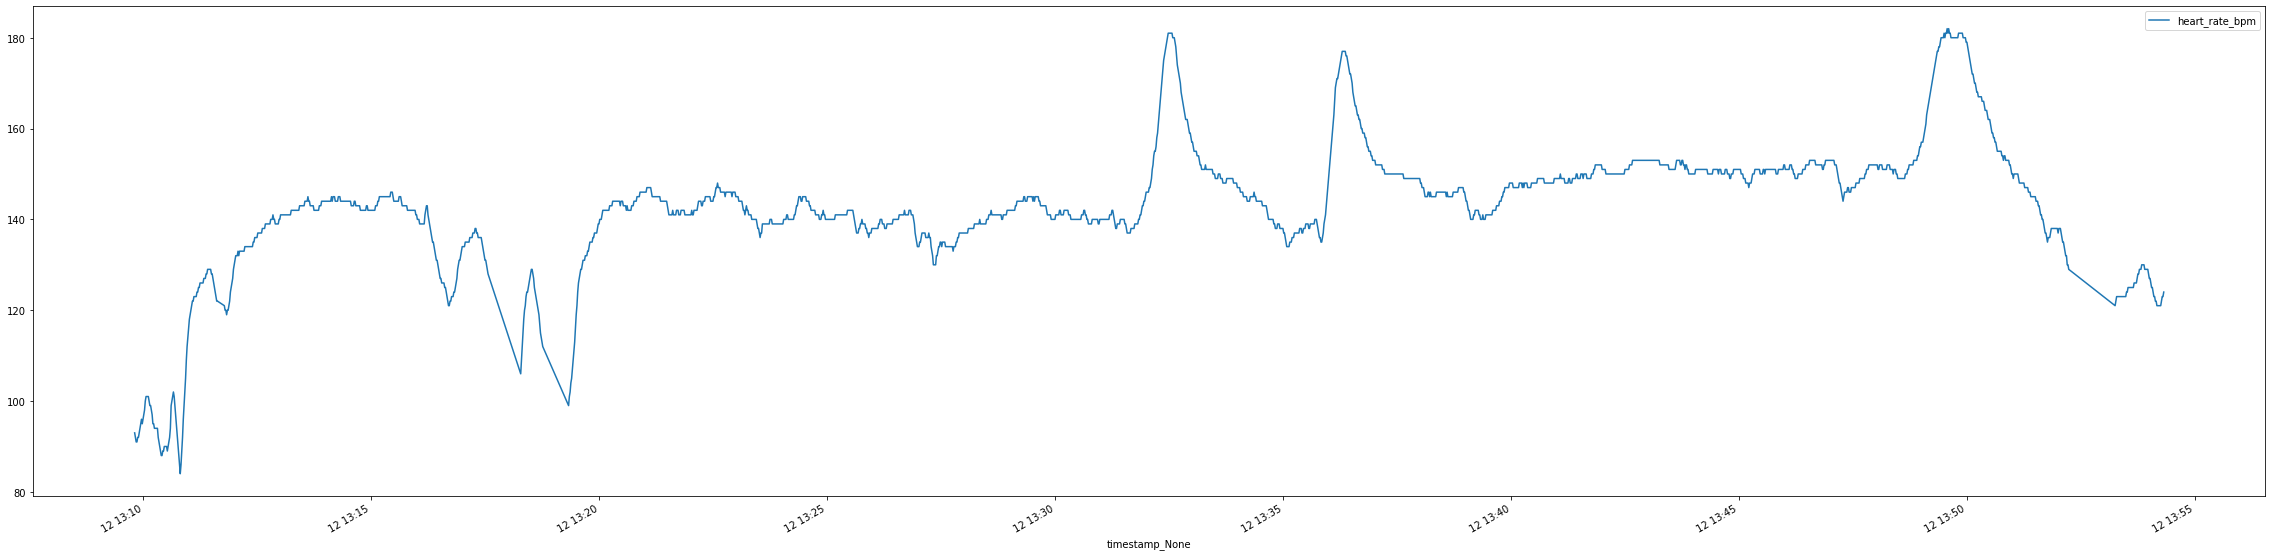

In [14]:
f2df.plot(x="timestamp_None", y="heart_rate_bpm", figsize=(40,10))

<AxesSubplot:xlabel='timestamp_None'>

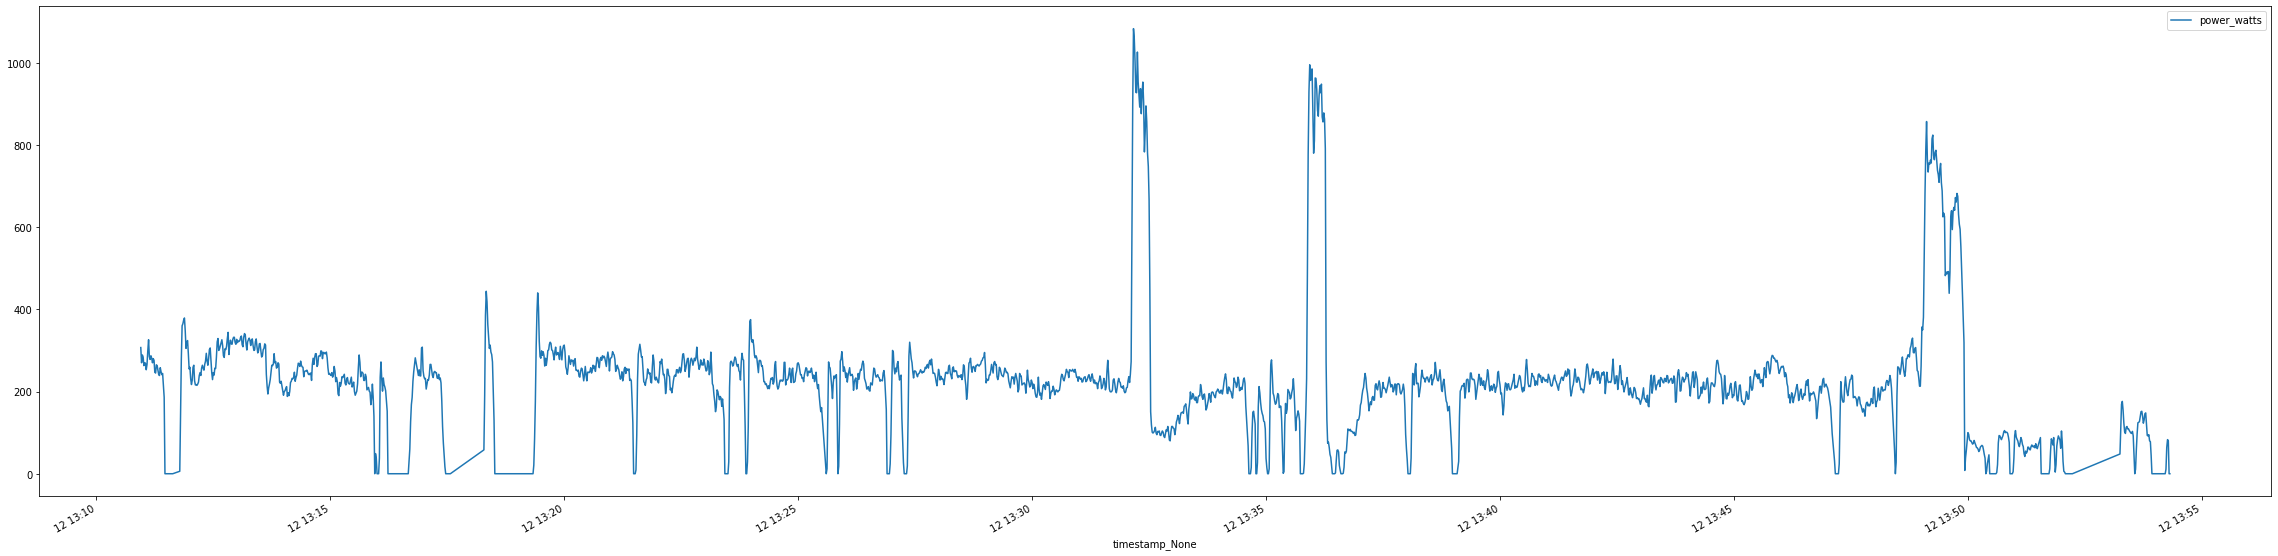

In [15]:
f2df.plot(x="timestamp_None", y="power_watts", figsize=(40,10))

<AxesSubplot:xlabel='timestamp_None', ylabel='grade_%'>

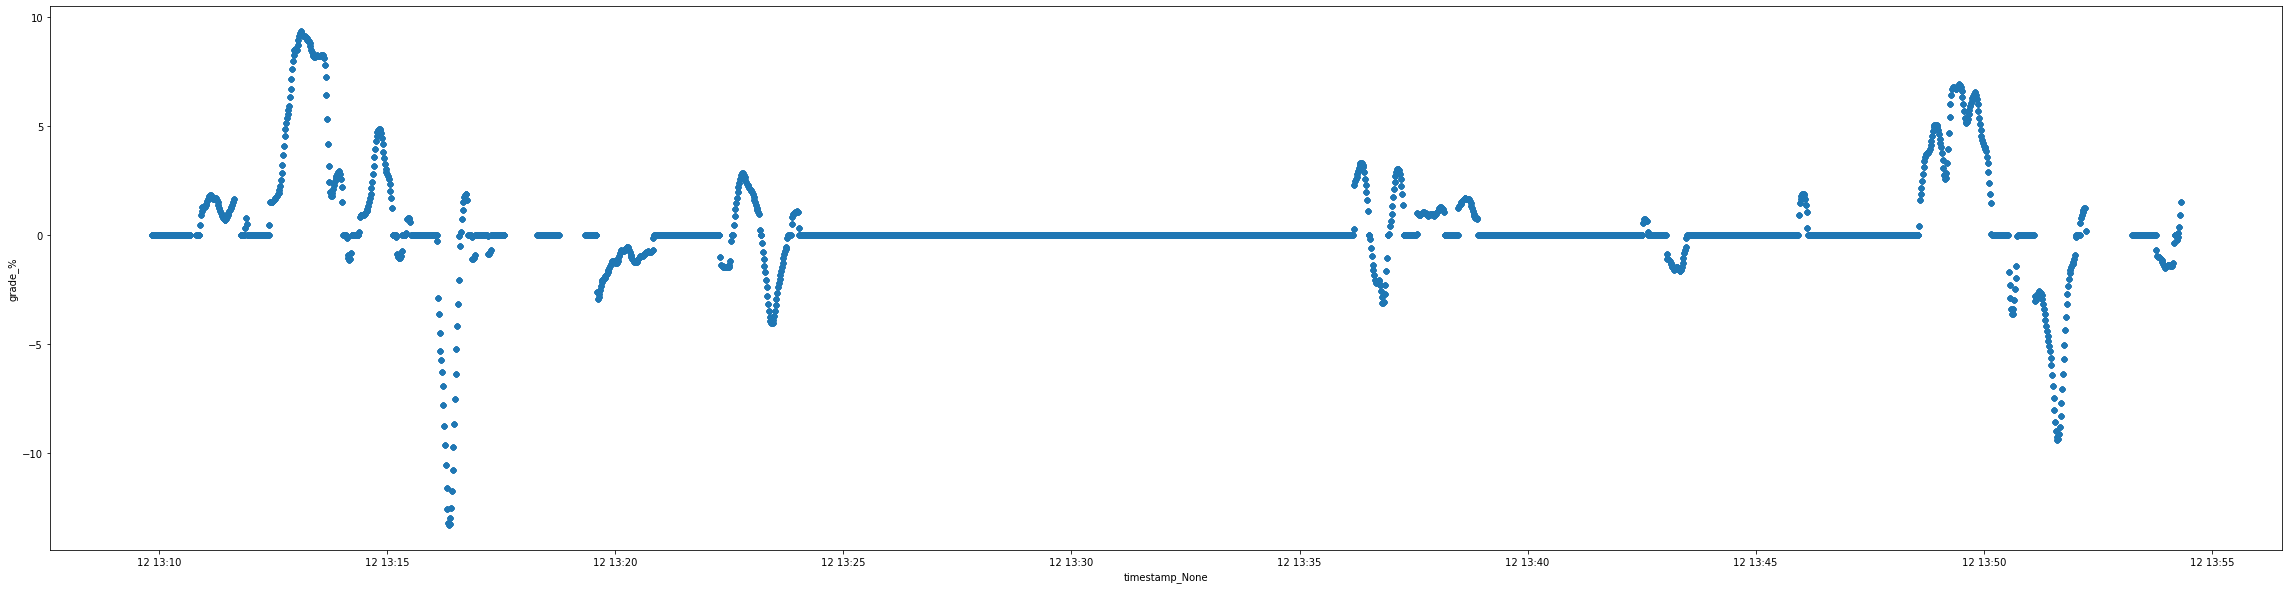

In [17]:
f2df.plot.scatter(x="timestamp_None", y="grade_%", figsize=(40,10))